,prop,other_resp,other_prop,time_spent_risk,cells,selfish,time_spent_prop,count_effort,Honesty_Humility,Extraversion,Agreeableness,min_offer
0,50,50,50,43000,26,60,31000,20,4.2,3.0,2.8,50
1,50,20,20,12000,7,20,38000,20,1.9,4.4,2.9,50
2,120,50,80,88000,50,20,69000,12,3.3,3.8,3.4,80
3,50,50,50,24000,50,60,26000,14,3.6,3.8,2.6,50
4,100,50,50,137000,24,60,43000,4,3.6,2.5,2.7,100


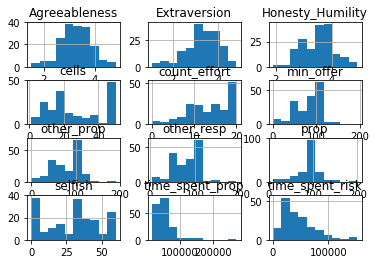

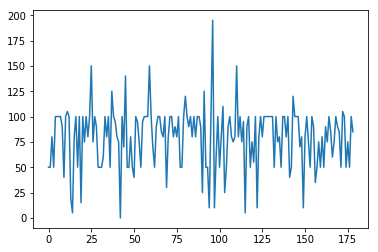

In [57]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

#fix rnd seed
np.random.seed(7)

# Read and sanitize the data
df = pd.read_excel("./UG_HH_NEW_continuous_no200.xls")
df = df.dropna()

#print(df[50:])

# Show head and histograms
display(df.head())
df.hist()

# Plot sample figure for min_offers
plt.figure()

x = range(0, len(df['prop']))
x1 = df['min_offer']

plt.plot(x, x1)

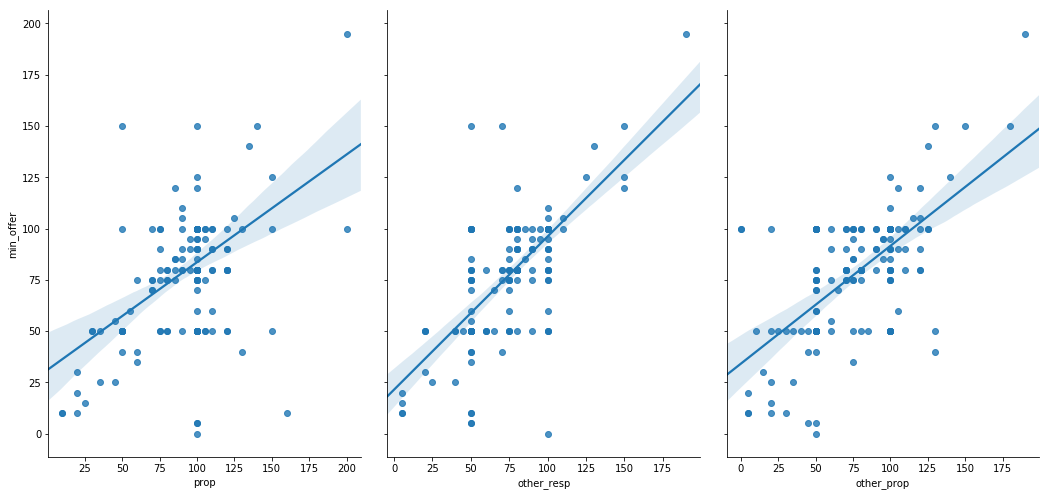

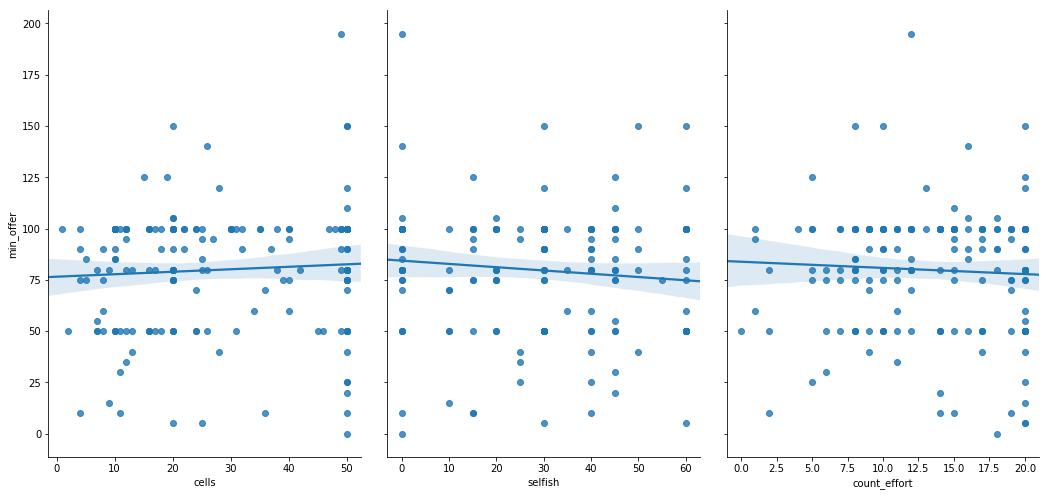

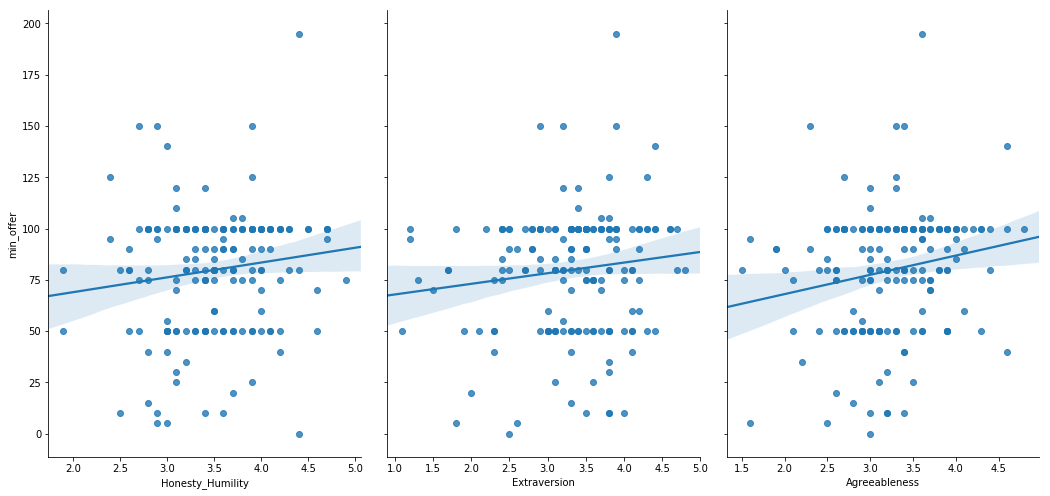

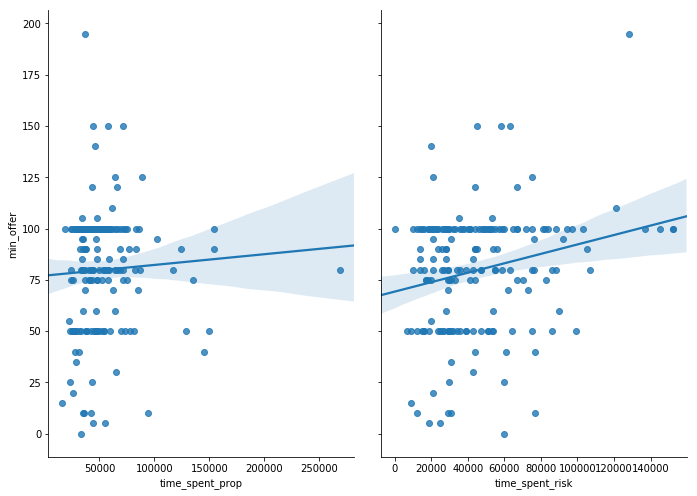

In [58]:
sb.pairplot(df, x_vars=('prop','other_resp','other_prop'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
sb.pairplot(df, x_vars=('cells', 'selfish','count_effort'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
sb.pairplot(df, x_vars=('Honesty_Humility', 'Extraversion','Agreeableness'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
sb.pairplot(df, x_vars=('time_spent_prop', 'time_spent_risk'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')

In [59]:
#manual ablation
#df = df.drop(columns=['cells','selfish','count_effort','Honesty_Humility','Extraversion','Agreeableness','time_spent_risk','time_spent_prop'])

In [60]:
from sklearn.linear_model import LinearRegression
# Split into inputs and oututs
x = df.iloc[:, :-1].values

y = df.iloc[:, -1:].values
NB_FEATURES = x.shape[1]
#print(x)
#print(y)

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)
#print(xTrain)
#print(yTrain)

# regressor = LinearRegression(copy_X=True).fit(xTrain, yTrain)

# print("Intercept:", regressor.intercept_)
# print("Coef:", regressor.coef_)

# yPredict = regressor.predict(xTest)
# print("R2:", r2_score(yTest, yPredict))

# out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPredict)})
# #print(out_data)

# out_data.plot(figsize=(30,10))

In [61]:
@np.vectorize
def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)

@np.vectorize
def sigmoid1024(x):
    return (1024**x/(1024**x + 1))

@np.vectorize
def sigmoid128(x):
    return (128**x/(128**x + 1))

# @np.vectorize
# def loss(x):
#     x = (x+10) / 40
#     return (1 - (sigmoid1024(x) * np.cos(x/np.pi))) / 2
    
# @np.vectorize
# def gain(x):
#     return 2 - loss(x)

# @np.vectorize
def gain(x):
    x = (x - 10) / 40
    return sigmoid1024(x) *  np.cos(x/np.pi)

@np.vectorize
def loss(x):
    return (1 - gain(x))

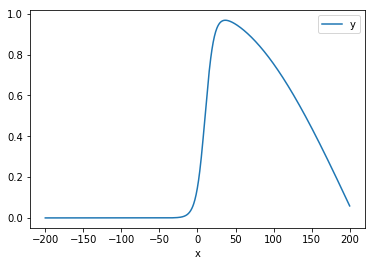

In [62]:
x = np.linspace(-200, 200, 1000)
y = gain(x)

df = pd.DataFrame({'x':x, 'y':y})
df.plot.line(x='x', y='y')

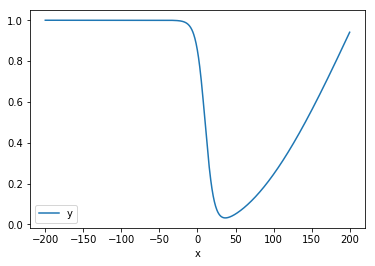

In [63]:
y = loss(x)

df = pd.DataFrame({'x':x, 'y':y})
df.plot.line(x='x', y='y')

In [126]:
#keras
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import multiply
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import sys


def sigmoid1024_tf(x):
    return (1024**x) / (1024**x + 1)

def sigmoid(x):
    return (K.exp(x) / K.exp(x) + 1)

def gain_tf(x):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(10.0)
    x = tf.math.subtract(y_true, y_pred)
    x = tf.math.truediv(x, ten)
    left_mul = sigmoid(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.multiply(left_mul, right_mul)

def loss_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(10.0)
    x0 = tf.math.subtract(y_true, y_pred)
    x = tf.math.truediv(x0, ten)
    left_mul = sigmoid1024(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.subtract(one*2, tf.math.multiply(left_mul, right_mul))

def _keras_model(loss=None, metrics=None):
    """
    build a simple regression model
    :param loss: (str|callable, default: mse)
    """
    if loss is None:
        loss = "mse"
    if metrics is None:
        metrics = ["mae"]
    model = Sequential()
    model.add(Dense(5, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

def keras_model(loss=None, metrics=None, nb_epoch=100, batch_size=32, verbose=False):
    build_fn = lambda : _keras_model(loss, metrics)
    return KerasRegressor(build_fn=build_fn, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)

In [127]:
#sci-kit like training
sm = keras_model(loss=loss_tf) 
history = sm.fit(xTrain.astype('float'), yTrain.astype('float'), validation_split=1/4, epochs=100, batch_size=8, verbose=0)
loss_hist = pd.DataFrame(data={'loss': history.history['loss']})
loss_hist.plot(figsize=(30,10))
smPredict = sm.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(smPredict)})
stl = sm.score(xTest, yTest, verbose=0)
print("Results: %2.2f (%.2f) MSE, Scalar test loss: %.2f" % (smPredict.mean(), smPredict.std(), stl))
#out_data.plot(figsize=(30,10))

TypeError: Expected binary or unicode string, got <tf.Tensor 'loss_30/dense_62_loss/truediv_2:0' shape=(?, ?) dtype=float32>

In [119]:

yPredict = sm.predict(xTest)
print("R2:", r2_score(yTest, yPredict))

R2: -412.03161023879454


In [ ]:
loss_baseline = "mse"
MAX_GAIN = 200.0

def gain(min_offer, predicted):
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res

def gain_mean(min_offer, predicted):
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res.mean()

In [121]:
gain(yTest.ravel()- yPredict).mean()

7.547752942173693e-08